# Define Dependencies

In [1]:
from sklearn.decomposition import PCA
import os
import scipy.io as sio
import numpy as np
from keras.models import load_model
from tensorflow.keras.utils import to_categorical  # Use this instead of np_utils
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import spectral
import matplotlib
%matplotlib inline


In [2]:
# Load the Global values (windowSize, numPCAcomponents, testRatio) from the text file global_variables.txt
myFile = open('global_variables.txt', 'r') 
file = myFile.readlines()[:]


for line in file:

    if line[0:3] == "win":

        ds = line.find('=')
        windowSize = int(line[ds+1:-1],10)

    elif line[0:3] == "num":

        ds = line.find('=')
        numPCAcomponents = int(line[ds+2:-1],10)

    else:

        ds = line.find('=')
        testRatio = float(line[ds+1:])


# Define the neccesary functions for later use

In [3]:
def loadIndianPinesData():
    data_path = os.path.join(os.getcwd(),'Data')
    data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
    labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    
    return data, labels

def reports (X_test,y_test):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
               ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
               'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
               'Stone-Steel-Towers']

    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy


def applyPCA(X, numPCAcomponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numPCAcomponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numPCAcomponents))
    return newX, pca

def Patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [4]:
X_test = np.load("X_testPatches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")


y_test = np.load("y_testPatches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")


In [5]:
from tensorflow.keras.utils import to_categorical  # Ensure this is imported at the top

# Reshape X_test as required
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[3], X_test.shape[1], X_test.shape[2]))

# Convert y_test to one-hot encoding
num_classes = len(np.unique(y_test))  # Ensure you set the number of classes
y_test = to_categorical(y_test, num_classes=num_classes)


In [6]:
# load the model architecture and weights
model = load_model('my_model' + str(windowSize) + 'PCA' + str(numPCAcomponents) + "testRatio" + str(testRatio) + '.h5')

In [7]:
# Using the pretrained model make predictions and print the results into a report
classification, confusion, Test_loss, Test_accuracy = reports(X_test,y_test)
classification = str(classification)
confusion = str(confusion)
file_name = 'report' + "WindowSize" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) +".txt"
with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8444 - loss: 0.4487   


# Build the Classification Maps

In [8]:
# load the original image
X, y = loadIndianPinesData()

In [9]:
X,pca = applyPCA(X,numPCAcomponents)

In [10]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numPCAcomponents = numPCAcomponents

In [11]:
import numpy as np

# Calculate the predicted image
height, width = 10, 10
outputs = np.zeros((height, width))
for i in range(height - PATCH_SIZE + 1):
    for j in range(width - PATCH_SIZE + 1):
        # Get the target value
        target = y[int(i + PATCH_SIZE / 2), int(j + PATCH_SIZE / 2)]
        
        # Skip processing if the target is 0
        if target == 0:
            continue
        
        # Extract the image patch
        image_patch = Patch(X, i, j)
        
        # Reshape the image patch for prediction
        X_test_image = image_patch.reshape(
            1, image_patch.shape[2], image_patch.shape[0], image_patch.shape[1]
        ).astype('float32')
        
        # Make a prediction using the model
        predictions = model.predict(X_test_image)
        
        # Get the predicted class
        prediction = np.argmax(predictions, axis=1)[0]  # Extract the scalar value
        
        # Update the output at the corresponding position
        outputs[int(i + PATCH_SIZE / 2)][int(j + PATCH_SIZE / 2)] = prediction + 1

# Optional: Print the outputs or check values for debugging



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━

D:\capstone\Classification-of-Hyperspectral-Image-master\your_env_name\lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


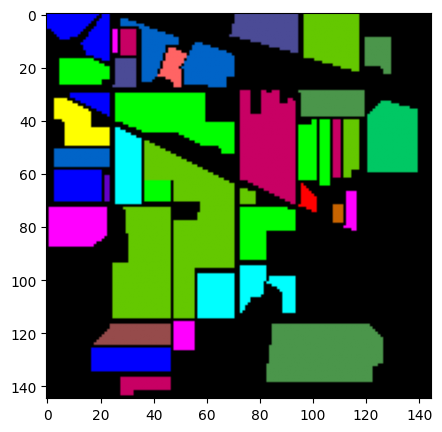

In [12]:
# Plot the Ground Truth Image
ground_truth = spectral.imshow(classes = y,figsize =(5,5))

In [13]:
import numpy as np
unique_classes = np.unique(y)
print(unique_classes)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


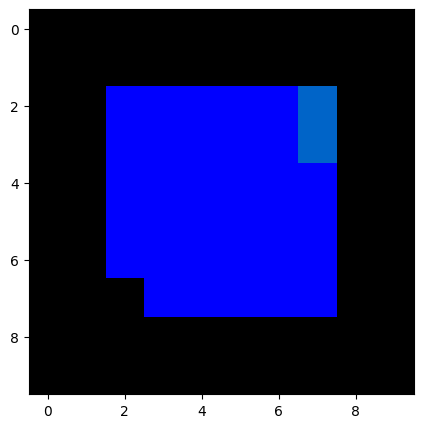

In [14]:
# Plot the Predicted image
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))

In [15]:
import numpy as np
unique_classes = np.unique(outputs)
print(unique_classes)


[ 0.  3. 12.]


In [16]:
target_names = [
    'Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn',
    'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
    'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
    'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
    'Stone-Steel-Towers'
]

# Check unique predicted class labels
import numpy as np
unique_classes = np.unique(outputs)

# Print class names corresponding to predicted class indices
# Convert class indices to integers before indexing
for class_index in unique_classes.astype(int):  
    print(f"Class {class_index}: {target_names[class_index]}")



Class 0: Alfalfa
Class 3: Corn
Class 12: Wheat


In [17]:
import numpy as np

unique_classes = np.unique(outputs.astype(int))  # Ensure integer values
print("Unique predicted classes:", unique_classes)


Unique predicted classes: [ 0  3 12]


In [18]:
import matplotlib.pyplot as plt

# Define class names
target_names = [
    'Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn',
    'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
    'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
    'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
    'Stone-Steel-Towers'
]

# Define a colormap with distinct colors for each class
colors = [
    'red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange',
    'purple', 'brown', 'pink', 'gray', 'lime', 'teal', 'navy',
    'gold', 'black'
]

# Create a mapping from class index to color and name
class_color_map = {i: (target_names[i], colors[i]) for i in range(len(target_names))}

# Print the mapping for predicted classes
print("\nPredicted Class - Name - Color Mapping:")
for class_index in unique_classes:
    if class_index in class_color_map:
        class_name, class_color = class_color_map[class_index]
        print(f"Class {class_index}: {class_name} -> {class_color}")
    else:
        print(f"Class {class_index}: Unknown (not in target names)")



Predicted Class - Name - Color Mapping:
Class 0: Alfalfa -> red
Class 3: Corn -> yellow
Class 12: Wheat -> teal


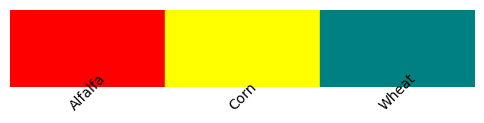

In [19]:
# Create a legend for predicted classes
fig, ax = plt.subplots(figsize=(6, 1))
ax.set_xlim(0, len(unique_classes))
ax.set_ylim(0, 1)
ax.axis('off')

# Draw color patches
for i, class_index in enumerate(unique_classes):
    class_index = int(class_index)  # Ensure it's an integer
    if class_index in class_color_map:
        class_name, class_color = class_color_map[class_index]
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=class_color))
        ax.text(i + 0.5, -0.3, class_name, ha='center', fontsize=10, rotation=45)

plt.show()
